In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# GIRIS

Projem, kardiyovasküler hastalıkların erken teşhisini yapabilecek bir yapay zekâ modeli (yapay sinir ağı) geliştirmeyi amaçlamaktadır. Kardiyovasküler hastalıklar, dünya çapında ölüm nedenlerinin başında gelmektedir ve yıllık yaklaşık 17.9 milyon kişinin ölümüne yol açmaktadır. Bu hastalıklar, erken teşhis ve uygun yönetimle önlenebilir veya etkileri azaltılabilir. Oluşturulacak makine öğrenmesi modeli, bireylerin hastalık risklerini tahmin ederek erken müdahaleye olanak sağlayacaktır. Ayrıca proje içerisinde hem öğrenme amaçlı hem de amacımıza ve veri setimize en uygun yapay sinir ağı ayarlarını bulmak için eğitim birkaç farklı şekilde gerçekleştirilip, karşılaştırmalar yapılmaktadır.

# VERI ONISLEME

Gerekli kutuphaneleri import ediyoruz.

In [2]:
import numpy as np    #Sayısal hesaplamalar ve veri manipülasyonu için kullanılır.
                      #Diziler ve çok boyutlu dizilerle çalışmayı kolaylaştırır.
                      #Hızlı ve verimli vektör operasyonları ve çeşitli matematiksel fonksiyonlar sağlar.

import pandas as pd   #Veri okuma, temizleme, analiz etme ve işleme için kullanılır.

import os             #Dosya ve dizin işlemlerini yapabilmek için kullanılır.
                      #Dosyaların bulunduğu dizini değiştirme veya mevcut dosyaları listeleme vb.
                      #Sistemle etkileşime geçip dosya yollarını yönetmenizi sağlar.

import seaborn as sns #İstatistiksel veri görselleştirmeleri yapar. Matplotlib üzerine kuruludur.
                      #Gelişmiş ve estetik grafikleri oluşturmanızı sağlar.
                      #Veri dağılımını, ilişkilerini ve kategorik verileri gösteren grafikler oluşturmak için kullanılır.


import matplotlib.pyplot as plt #Temel ve esnek veri görselleştirmeleri yapar.

import plotly.express as px #Etkileşimli ve dinamik grafikler oluşturur. Kullanıcıların grafiklerle etkileşime girmesini sağlayan güçlü bir araçtır.
                            #3D grafikler, coğrafi haritalar ve hareketli grafikler gibi ileri seviye görselleştirmeleri destekler.

from sklearn.model_selection import train_test_split  # Eğitim ve test verilerini ayırmak için
from sklearn.preprocessing import StandardScaler      # Veri ölçeklendirme
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Konfüzyon matrisi oluşturmak için
from sklearn.model_selection import KFold, cross_val_score

#Veri ön işleme (özellik ölçeklendirme, sınıf dengesizliği düzeltme vb.).
#Cross-validation (5 fold ve 10 fold gibi).

import tensorflow as tf
import keras

Veri setimizi pandas data frame'e yukuyoruz.

In [3]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

Veri setimizi goruntuluyoruz

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [6]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Kategorik degeleri ile sayisal degerleri ayiriyoruz

In [7]:
categorical_features = []
numerical_features = []

for col in df.columns:
    if (df[col].dtype == "object") or (df[col].dtype == "categorical"):
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(numerical_features)
print(categorical_features)

for col in df.columns:
    if col in categorical_features:
        df[col]=pd.Categorical(df[col])


['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 55.5 KB


Eksik degerler var mi yok mu diye kontrol ediyoruz

In [9]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [10]:
for column in df.columns:
    if df[column].dtype == "category" :
        print(f"Unique values in '{column}':")
        print(df[column].unique())
        print("-" * 50)


Unique values in 'Sex':
['M', 'F']
Categories (2, object): ['F', 'M']
--------------------------------------------------
Unique values in 'ChestPainType':
['ATA', 'NAP', 'ASY', 'TA']
Categories (4, object): ['ASY', 'ATA', 'NAP', 'TA']
--------------------------------------------------
Unique values in 'RestingECG':
['Normal', 'ST', 'LVH']
Categories (3, object): ['LVH', 'Normal', 'ST']
--------------------------------------------------
Unique values in 'ExerciseAngina':
['N', 'Y']
Categories (2, object): ['N', 'Y']
--------------------------------------------------
Unique values in 'ST_Slope':
['Up', 'Flat', 'Down']
Categories (3, object): ['Down', 'Flat', 'Up']
--------------------------------------------------


Veri setimizi daha iyi anlamak icin hizli bir gorsellestirme yapiyoruz

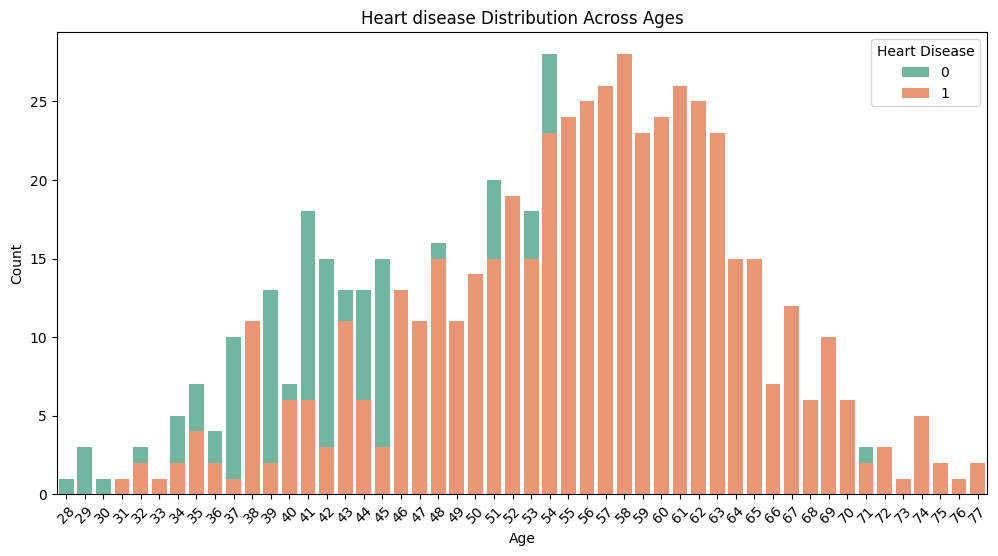

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Age', hue='HeartDisease', palette='Set2', dodge=False)
plt.title('Heart disease Distribution Across Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Heart Disease')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Sayisal verilerimiz farkli olceklerde oldugu icin, egitim asamasina gecmeden once standard scaler ile z-skor normalizasyonu uyguluyoruz

In [12]:
scaler = StandardScaler()

numerical_features_normalization = [feature for feature in numerical_features if feature not in ['HeartDisease', 'FastingBS']]

df[numerical_features_normalization]=scaler.fit_transform(df[numerical_features_normalization])

In [13]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,-0.832432,Up,0
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,0.105664,Flat,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,-0.832432,Up,0
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,0.574711,Flat,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,-0.832432,Up,0


Yapay sinir aglari sadece sayisal girisler ile calistiklari icin, kategorik degerlerimizi de one hot encoding yontemi ile sayisal degerlere donusturuyoruz

In [14]:
df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

In [15]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,0,True,True,False,False,True,False,False,False,True
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,1,False,False,True,False,True,False,False,True,False
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,0,True,True,False,False,False,True,False,False,True
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,1,False,False,False,False,True,False,True,True,False
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,0,True,False,True,False,True,False,False,False,True


In [16]:
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

In [17]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,0,1,1,0,0,1,0,0,0,1
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,1,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,0,1,1,0,0,0,1,0,0,1
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,1,0,0,0,0,1,0,1,1,0
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,0,1,0,1,0,1,0,0,0,1


# YAPAY SINIR AGINI OLUSTURMA

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

Veri setimizi bagimsiz ve bagimli degiskenlere ayiriyoruz

In [19]:
X = df.drop(columns=['HeartDisease'])  
y = df['HeartDisease']  

In [20]:
print("Shape of X:", X.shape)  
print("Shape of y:", y.shape)  

Shape of X: (918, 15)
Shape of y: (918,)


In [21]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,1,1,0,0,1,0,0,0,1
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,1,1,0,0,0,1,0,0,1
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,0,0,0,0,1,0,1,1,0
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,1,0,1,0,1,0,0,0,1


In [22]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

# 1. AŞAMA : EGITIM SETI = TEST SETI

In [23]:
# Yapay sinir agi modelini olusturuyoruz
model = Sequential([
    Dense(16, input_dim=X.shape[1], activation='relu'),  # First hidden layer
    Dense(8, activation='relu'),                        # Second hidden layer
    Dense(1, activation='sigmoid')                      # Output layer (binary classification)
])


model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])        # Metric to track during training


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Modelin eğitilmesi
history = model.fit(X, y, 
                    epochs=500, #bu parametre degistirilebilir
                    batch_size=16, 
                    verbose=1)


Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9572 - loss: 0.1480
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 0.1504
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9497 - loss: 0.1710
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9483 - loss: 0.1689
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9415 - loss: 0.1796
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9460 - loss: 0.1738
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9582 - loss: 0.1445
Epoch 8/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.1814
Epoch 9/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9487 - loss: 0.1586
Epoch 10/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9562 - loss: 0.1507
Epoch 11/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1449
Epoch 12/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [30]:
# Modeli degerlendiriyoruz
loss, accuracy = model.evaluate(X, y, verbose=1)
print(f"Model Accuracy: {accuracy * 100:.2f}%, Loss : {loss * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9961 - loss: 0.0179 
Model Accuracy: 99.13%, Loss : 2.58%


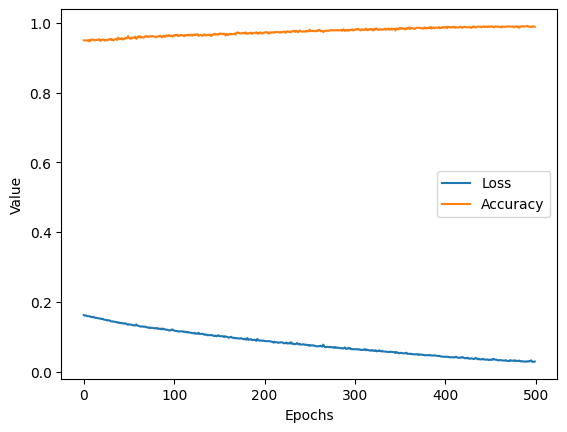

In [31]:
# Eğitim tamamlandıktan sonra loss ve accuracy grafikleri için:

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

# Veri seti üzerinde tahmin yapılması
y_pred = model.predict(X)  # Tahminler
y_pred_binary = (y_pred > 0.5).astype(int)  # 0 ve 1 sınıflarına dönüştürme
acc = accuracy_score(y, y_pred_binary)

# Performans değerlendirme
print("Confusion Matrix:\n", confusion_matrix(y, y_pred_binary))
print("\nClassification Report:\n", classification_report(y, y_pred_binary))


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[403   7]
 [  1 507]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       410
           1       0.99      1.00      0.99       508

    accuracy                           0.99       918
   macro avg       0.99      0.99      0.99       918
weighted avg       0.99      0.99      0.99       918



# 2. AŞAMA : 5 fold cross validation kullanarak egitim

In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
# Model oluşturma fonksiyonu
def create_model():
    model = Sequential([
        Dense(16, input_dim=X.shape[1], activation='relu'),  # İlk gizli katman
        Dense(8, activation='relu'),                        # İkinci gizli katman
        Dense(1, activation='sigmoid')                      # Çıkış katmanı
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [38]:
# KFold ayarları
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
fold = 1
accuracies = []
losses = []
all_confusion_matrices = []

# 5-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    print(f"Fold {fold}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # iloc kullanımı
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # iloc kullanımı
    
    # Yeni model oluştur ve eğit
    model = create_model()
    
    # Modeli eğit
    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model Accuracy for fold {fold}: {accuracy * 100:.2f}%")
    print(f"Model Loss for fold {fold}: {loss * 100:.2f}%")
    

    # Tahmin yap ve değerlendirme (optional)
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred_binary)

    print(acc)
    
    cm = confusion_matrix(y_test, y_pred_binary)

    print(f"Confusion Matrix for fold {fold}:\n{cm}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))
    
    accuracies.append(accuracy)
    losses.append(loss)
    all_confusion_matrices.append(cm)
    
    fold += 1

# Ortalama doğruluk ve sonuçlar
print("\n--- Final Results ---")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Mean Loss: {np.mean(losses) * 100:.2f}%")
print(f"Accuracy Std Dev: {np.std(accuracies) * 100:.2f}%")

Fold 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 1: 86.41%
Model Loss for fold 1: 38.31%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0.8641304347826086
Confusion Matrix for fold 1:
[[64 13]
 [12 95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84        77
           1       0.88      0.89      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Fold 2


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 2: 85.33%
Model Loss for fold 2: 47.03%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0.8532608695652174
Confusion Matrix for fold 2:
[[60 10]
 [17 97]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82        70
           1       0.91      0.85      0.88       114

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

Fold 3


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 3: 85.87%
Model Loss for fold 3: 50.11%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0.8586956521739131
Confusion Matrix for fold 3:
[[70 18]
 [ 8 88]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.84        88
           1       0.83      0.92      0.87        96

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Fold 4


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 4: 81.97%
Model Loss for fold 4: 70.46%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
0.819672131147541
Confusion Matrix for fold 4:
[[66 18]
 [15 84]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        84
           1       0.82      0.85      0.84        99

    accuracy                           0.82       183
   macro avg       0.82      0.82      0.82       183
weighted avg       0.82      0.82      0.82       183

Fold 5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 5: 86.89%
Model Loss for fold 5: 39.36%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0.8688524590163934
Confusion Matrix for fold 5:
[[70 21]
 [ 3 89]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.77      0.85        91
           1       0.81      0.97      0.88        92

    accuracy                           0.87       183
   macro avg       0.88      0.87      0.87       183
weighted avg       0.88      0.87      0.87       183


--- Final Results ---
Mean Accuracy: 85.29%
Mean Loss: 49.05%
Accuracy Std Dev: 1.74%


# 3. AŞAMA : 10 fold cross validation kullanarak egitim

In [45]:
# KFold ayarları
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [49]:
fold = 1
accuracies = []
losses = []
all_confusion_matrices = []

# 10-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    print(f"Fold {fold}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # iloc kullanımı
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # iloc kullanımı
    
    # Yeni model oluştur ve eğit
    model = create_model()
    
    # Modeli eğit
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model Accuracy for fold {fold}: {accuracy * 100:.2f}%")
    print(f"Model Loss for fold {fold}: {loss * 100:.2f}%")
    

    # Tahmin yap ve değerlendirme (optional)
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred_binary)

    print(acc)
    
    cm = confusion_matrix(y_test, y_pred_binary)

    print(f"Confusion Matrix for fold {fold}:\n{cm}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))
    
    accuracies.append(accuracy)
    losses.append(loss)
    all_confusion_matrices.append(cm)
    
    fold += 1

# Ortalama doğruluk ve sonuçlar
print("\n--- Final Results ---")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Mean Loss: {np.mean(losses) * 100:.2f}%")
print(f"Accuracy Std Dev: {np.std(accuracies) * 100:.2f}%")

Fold 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 1: 85.87%
Model Loss for fold 1: 33.40%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.8586956521739131
Confusion Matrix for fold 1:
[[30  8]
 [ 5 49]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82        38
           1       0.86      0.91      0.88        54

    accuracy                           0.86        92
   macro avg       0.86      0.85      0.85        92
weighted avg       0.86      0.86      0.86        92

Fold 2


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 2: 88.04%
Model Loss for fold 2: 26.47%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.8804347826086957
Confusion Matrix for fold 2:
[[35  4]
 [ 7 46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86        39
           1       0.92      0.87      0.89        53

    accuracy                           0.88        92
   macro avg       0.88      0.88      0.88        92
weighted avg       0.88      0.88      0.88        92

Fold 3


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 3: 93.48%
Model Loss for fold 3: 20.57%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.9347826086956522
Confusion Matrix for fold 3:
[[32  3]
 [ 3 54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.95      0.95      0.95        57

    accuracy                           0.93        92
   macro avg       0.93      0.93      0.93        92
weighted avg       0.93      0.93      0.93        92

Fold 4


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 4: 82.61%
Model Loss for fold 4: 42.07%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.8260869565217391
Confusion Matrix for fold 4:
[[30  5]
 [11 46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        35
           1       0.90      0.81      0.85        57

    accuracy                           0.83        92
   macro avg       0.82      0.83      0.82        92
weighted avg       0.84      0.83      0.83        92

Fold 5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 5: 90.22%
Model Loss for fold 5: 27.24%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.9021739130434783
Confusion Matrix for fold 5:
[[41  6]
 [ 3 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        47
           1       0.88      0.93      0.90        45

    accuracy                           0.90        92
   macro avg       0.90      0.90      0.90        92
weighted avg       0.90      0.90      0.90        92

Fold 6


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 6: 86.96%
Model Loss for fold 6: 29.88%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.8695652173913043
Confusion Matrix for fold 6:
[[31 10]
 [ 2 49]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84        41
           1       0.83      0.96      0.89        51

    accuracy                           0.87        92
   macro avg       0.88      0.86      0.86        92
weighted avg       0.88      0.87      0.87        92

Fold 7


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 7: 84.78%
Model Loss for fold 7: 40.82%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.8478260869565217
Confusion Matrix for fold 7:
[[35  7]
 [ 7 43]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        42
           1       0.86      0.86      0.86        50

    accuracy                           0.85        92
   macro avg       0.85      0.85      0.85        92
weighted avg       0.85      0.85      0.85        92

Fold 8


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 8: 80.43%
Model Loss for fold 8: 44.00%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.8043478260869565
Confusion Matrix for fold 8:
[[32 10]
 [ 8 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78        42
           1       0.81      0.84      0.82        50

    accuracy                           0.80        92
   macro avg       0.80      0.80      0.80        92
weighted avg       0.80      0.80      0.80        92

Fold 9


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 9: 90.11%
Model Loss for fold 9: 23.92%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.9010989010989011
Confusion Matrix for fold 9:
[[37  6]
 [ 3 45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89        43
           1       0.88      0.94      0.91        48

    accuracy                           0.90        91
   macro avg       0.90      0.90      0.90        91
weighted avg       0.90      0.90      0.90        91

Fold 10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for fold 10: 82.42%
Model Loss for fold 10: 48.66%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.8241758241758241
Confusion Matrix for fold 10:
[[35 13]
 [ 3 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81        48
           1       0.75      0.93      0.83        43

    accuracy                           0.82        91
   macro avg       0.84      0.83      0.82        91
weighted avg       0.84      0.82      0.82        91


--- Final Results ---
Mean Accuracy: 86.49%
Mean Loss: 33.70%
Accuracy Std Dev: 3.87%


# 4. AŞAMA : .%66-%34 eğitim test ayırarak (5 farklı rassal ayırma ile) egitim

In [51]:
accuracies = []
all_confusion_matrices = []
losses=[]


In [56]:
for i in range(5):
    print(f"Split {i+1}")
    
    # Veri setini %66 eğitim ve %34 test olarak ayır
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, shuffle=True, random_state=np.random.randint(0, 1000))
    
    # Yapay sinir ağı modelini oluştur ve eğit
    model = create_model()
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    
    # Test verisi ile değerlendirme
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model Accuracy for split {i+1}: {accuracy * 100:.2f}%")
    print(f"Model Loss for split {fold}: {loss * 100:.2f}%")
    
    # Tahmin yap ve konfüzyon matrisi oluştur
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)  # binary sınıflandırma için
    cm = confusion_matrix(y_test, y_pred_binary)
    
    print(f"Confusion Matrix for split {i+1}:\n{cm}")
    all_confusion_matrices.append(cm)

    print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))
    
    accuracies.append(accuracy)
    losses.append(loss)
    

Split 1


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for split 1: 83.07%
Model Loss for split 11: 60.42%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix for split 1:
[[125  22]
 [ 31 135]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       147
           1       0.86      0.81      0.84       166

    accuracy                           0.83       313
   macro avg       0.83      0.83      0.83       313
weighted avg       0.83      0.83      0.83       313

Split 2


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for split 2: 85.30%
Model Loss for split 11: 34.42%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix for split 2:
[[107  34]
 [ 12 160]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82       141
           1       0.82      0.93      0.87       172

    accuracy                           0.85       313
   macro avg       0.86      0.84      0.85       313
weighted avg       0.86      0.85      0.85       313

Split 3


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for split 3: 89.14%
Model Loss for split 11: 30.09%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix for split 3:
[[113  22]
 [ 12 166]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87       135
           1       0.88      0.93      0.91       178

    accuracy                           0.89       313
   macro avg       0.89      0.88      0.89       313
weighted avg       0.89      0.89      0.89       313

Split 4


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for split 4: 89.14%
Model Loss for split 11: 31.35%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix for split 4:
[[113  24]
 [ 10 166]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       137
           1       0.87      0.94      0.91       176

    accuracy                           0.89       313
   macro avg       0.90      0.88      0.89       313
weighted avg       0.89      0.89      0.89       313

Split 5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy for split 5: 84.35%
Model Loss for split 11: 45.43%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix for split 5:
[[113  27]
 [ 22 151]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       140
           1       0.85      0.87      0.86       173

    accuracy                           0.84       313
   macro avg       0.84      0.84      0.84       313
weighted avg       0.84      0.84      0.84       313



In [57]:
# Ortalama doğruluk ve sonuçlar
print("\n--- Final Results ---")
print(f"Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")
print(f"Mean Loss: {np.mean(losses) * 100:.2f}%")
print(f"Accuracy Std Dev: {np.std(accuracies) * 100:.2f}%")


--- Final Results ---
Mean Accuracy: 86.01%
Mean Loss: 37.68%
Accuracy Std Dev: 1.95%
